In [30]:
import pyspark as ps
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, array
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [31]:
sc = spark.sparkContext

In [32]:
def auth_casting_function(row):
    (time, scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success) = row
    feilds = [time, scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success]
    
    print('success')
    if(time=='?'):
        time = 666999666
    return (int(time),scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success)

In [33]:
def proc_casting_function(row):
    (time,user_domain,comp,proc_name,start) = row
    if(time=='?'):
        time = 666999666
    return (int(time),user_domain,comp,proc_name,start)

In [34]:
def flow_casting_function(row):
    (time, duration,src_comp,src_port,dst_comp,dst_port,protocol,pk_count,byte_count) = row
    if(time=='?'):
        time = 666999666
    return (int(time),int(duration),src_comp,src_port,dst_comp,dst_port,protocol,int(pk_count),int(byte_count))

In [35]:
def DNS_casting_function(row):
    (time, src_comp,comp_resolved) = row
    if(time=='?'):
        time = 666999666
    return (int(time),src_comp,comp_resolved)

In [36]:
# import the many data types
from pyspark.sql.types import *

# create a schema of your own
auth_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_user_domain',   StringType(),  True),
    StructField('dst_user_domain',   StringType(),  True),
    StructField('src_comp',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('auth_type',  StringType(), True),
    StructField('logon_type',  StringType(),  True),
    StructField('auth_orientation',  StringType(),  True),
    StructField('Success',  StringType(),  True)] )

proc_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('user_domain',   StringType(),  True),
    StructField('comp',   StringType(),  True),
    StructField('proc_name',   StringType(),  True),
    StructField('start',   StringType(),  True),
    ] )

flow_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('duration',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('src_port',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('dst_port',   StringType(),  True),
    StructField('protocol',  StringType(), True),
    StructField('pk_count',  LongType(),  True),
    StructField('byte_count',  LongType(),  True)] )

DNS_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('comp_resolved',   StringType(),  True),
    
    ] )

## Create RDDS from Text Input

rdd_auth = (sc.textFile('data/auth.txt')
            .map(lambda rowstr : rowstr.split(","))
            .map(auth_casting_function)
           )

rdd_proc = (sc.textFile('data/proc.txt')
            .map(lambda rowstr : rowstr.split(","))
            .map(proc_casting_function)
           )

rdd_flow = (sc.textFile('data/flows.txt')
            .map(lambda rowstr : rowstr.split(","))
            .map(flow_casting_function)
           )

rdd_DNS = (sc.textFile('data/dns.txt')
            .map(lambda rowstr : rowstr.split(","))
            .map(DNS_casting_function)
           )

## Create DataFrames from RDDs and 

In [37]:
auth_df = spark.createDataFrame(rdd_auth,auth_schema)

proc_df = spark.createDataFrame(rdd_proc,proc_schema)

flow_df = spark.createDataFrame(rdd_flow,flow_schema)

DNS_df = spark.createDataFrame(rdd_DNS,DNS_schema)

In [38]:
active_comps_df = pd.read_csv('Summary/Day1/active_comps_df.csv')
active_user_df= pd.read_csv('Summary/Day1/active_users_df.csv')
active_red_team =pd.read_csv('Summary/Day1/active_red_team.csv')

In [39]:
active_comps_df.columns = ['ignore','comp','count']

In [40]:
active_flow_df = flow_df.where(col("src_comp").isin(list(active_comps_df['comp'])) | col("dst_comp").isin(list(active_comps_df['comp'])))

red_flow_df = flow_df.where(col("src_comp").isin(list(active_red_team['dst_comp'])) | col("dst_comp").isin(list(active_red_team['dst_comp'])))




In [41]:
active_flow_df.collect()

[Row(time=47737, duration=0, src_comp='C2908', src_port='N217', dst_comp='C467', dst_port='N218', protocol='1', pk_count=1, byte_count=60),
 Row(time=47737, duration=0, src_comp='C3623', src_port='N3257', dst_comp='C706', dst_port='80', protocol='6', pk_count=8, byte_count=3632),
 Row(time=47737, duration=0, src_comp='C467', src_port='N218', dst_comp='C2908', dst_port='N218', protocol='1', pk_count=1, byte_count=60),
 Row(time=47737, duration=0, src_comp='C528', src_port='N218', dst_comp='C3871', dst_port='N218', protocol='1', pk_count=2, byte_count=120),
 Row(time=47737, duration=0, src_comp='C5721', src_port='139', dst_comp='C8207', dst_port='N15015', protocol='6', pk_count=1, byte_count=48),
 Row(time=47737, duration=0, src_comp='C5721', src_port='445', dst_comp='C11116', dst_port='N3297', protocol='6', pk_count=10, byte_count=2276),
 Row(time=47737, duration=0, src_comp='C706', src_port='80', dst_comp='C3623', dst_port='N3257', protocol='6', pk_count=7, byte_count=4128),
 Row(time=

In [42]:
add_download = udf(lambda x : 1 if x in list(active_comps_df['comp']) else 0 )
add_upload = udf(lambda x : 1 if x in list(active_comps_df['comp']) else 0 )

In [43]:
active_flow_df = active_flow_df.withColumn('Download', add_download(active_flow_df['dst_comp']))
active_flow_df = active_flow_df.withColumn('Upload', add_upload(active_flow_df['src_comp']))

In [44]:
red_flow_df = red_flow_df.withColumn('Download', add_download(red_flow_df['dst_comp']))
red_flow_df = red_flow_df.withColumn('Upload', add_upload(red_flow_df['src_comp']))

In [45]:
add_count = udf(lambda x : x[1] if x[0]=='1' else 0 )

In [46]:
active_flow_df = active_flow_df.withColumn('upload_bytes',add_count(array('Upload','byte_count')))
active_flow_df = active_flow_df.withColumn('download_bytes',add_count(array('Download','byte_count')))
active_flow_df = active_flow_df.withColumn('upload_pk',add_count(array('Upload','pk_count')))
active_flow_df = active_flow_df.withColumn('download_pk',add_count(array('Download','pk_count')))

In [47]:
red_flow_df = red_flow_df.withColumn('upload_bytes',add_count(array('Upload','byte_count')))
red_flow_df = red_flow_df.withColumn('download_bytes',add_count(array('Download','byte_count')))
red_flow_df = red_flow_df.withColumn('upload_pk',add_count(array('Upload','pk_count')))
red_flow_df = red_flow_df.withColumn('download_pk',add_count(array('Download','pk_count')))

In [48]:
interval_size = 3600
make_interval = udf(lambda x :  (x//interval_size)*interval_size)

In [49]:
 active_flow_df = active_flow_df.withColumn('interval', make_interval(active_flow_df['time']))

In [50]:
red_flow_df = red_flow_df.withColumn('interval', make_interval(active_flow_df['time']))

In [51]:
flow_time_series = active_flow_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum','upload_bytes':'sum','download_bytes':'sum','upload_pk':'sum','download_pk':'sum'}).collect()



In [52]:
red_flow_time_series = red_flow_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum','upload_bytes':'sum','download_bytes':'sum','upload_pk':'sum','download_pk':'sum'}).collect()




In [53]:
flow_time_series_df = pd.DataFrame(flow_time_series)
flow_time_series_df.columns = ['time','mean_duration','pk_count','byte_count','upload_bytes','download_bytes','upload_pk','download_pk']


In [54]:
red_flow_time_series_df = pd.DataFrame(red_flow_time_series)
red_flow_time_series_df.columns = ['time','mean_duration','pk_count','byte_count','upload_bytes','download_bytes','upload_pk','download_pk']


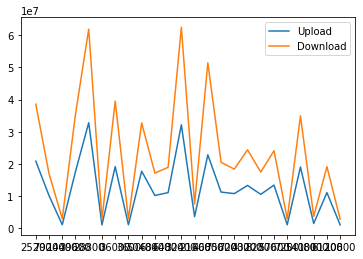

In [55]:
plt.plot(flow_time_series_df['time'],flow_time_series_df['upload_bytes'],label = 'Upload')
plt.plot(flow_time_series_df['time'],flow_time_series_df['download_bytes'],label = 'Download')
plt.legend()

(1, 5)

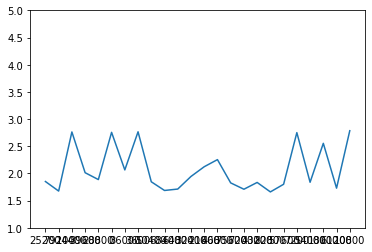

In [63]:
plt.plot(flow_time_series_df['time'],flow_time_series_df['download_bytes']/flow_time_series_df['upload_bytes'])




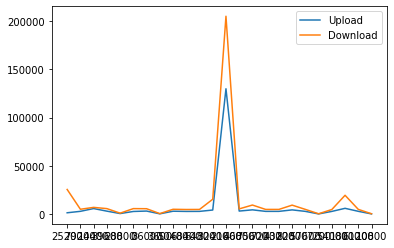

In [57]:
plt.plot(red_flow_time_series_df['time'],red_flow_time_series_df['upload_bytes'],label = 'Upload')
plt.plot(red_flow_time_series_df['time'],red_flow_time_series_df['download_bytes'],label = 'Download')

plt.legend()

(1, 5)

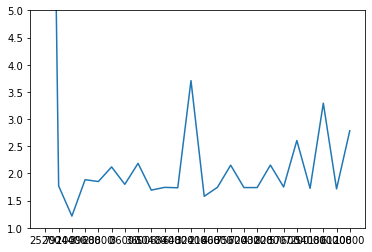

In [62]:
plt.plot(red_flow_time_series_df['time'],red_flow_time_series_df['download_bytes']/red_flow_time_series_df['upload_bytes'])



